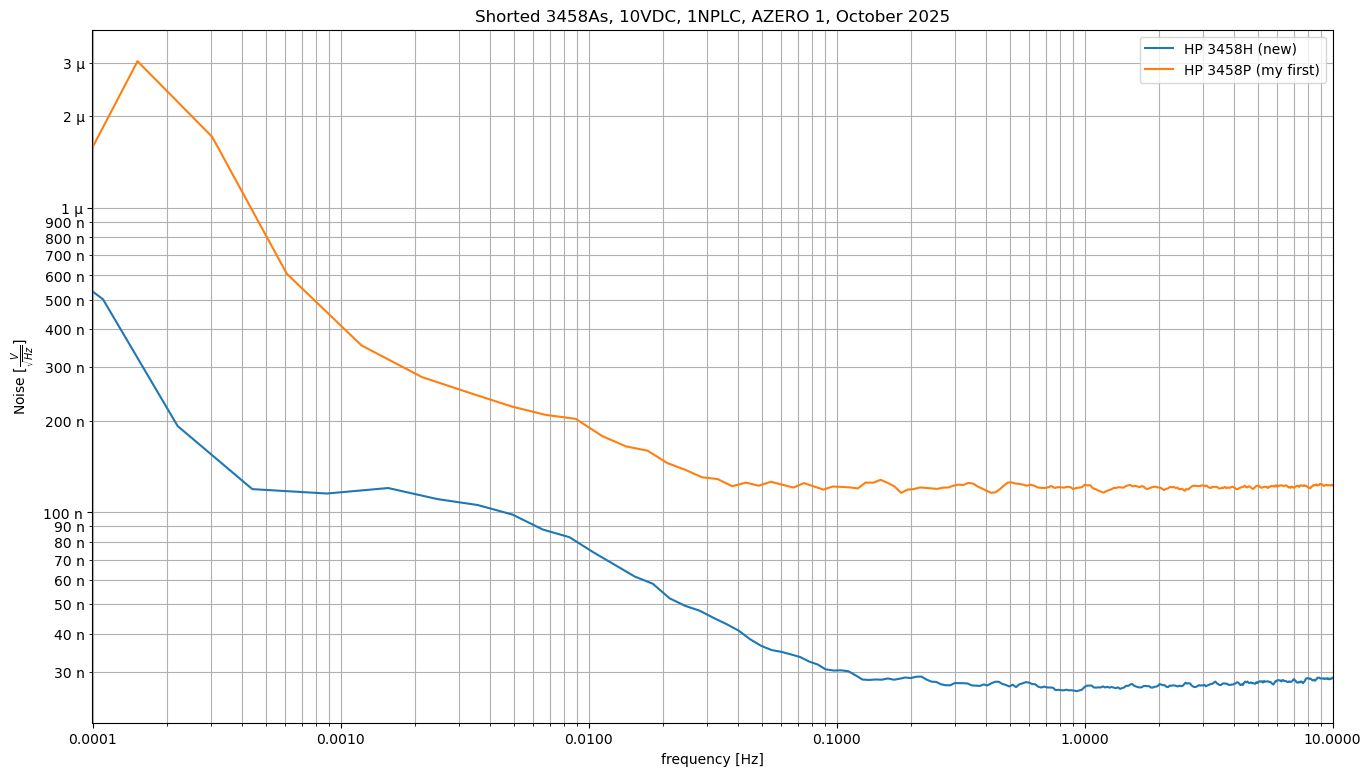

In [15]:
import pandas as pd
from lpsd import lpsd, flattop # https://gitlab.com/uhh-gwd/lpsd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import EngFormatter

# Set up plot
fig,ax = plt.subplots(figsize=(16,9))
plt.loglog()
plt.xlim([0.0001,10])
plt.xlabel('frequency [Hz]')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.yaxis.set_major_formatter(EngFormatter())
ax.yaxis.set_minor_formatter(EngFormatter())
plt.ylabel(r'Noise [$\frac{V}{\sqrt{Hz}}$]')
plt.grid(True, which="both")
plt.title('Shorted 3458As, 10VDC, 1NPLC, AZERO 1, October 2025')

# Array from .csv
df = pd.read_csv('https://github.com/marcoreps/3458a/raw/refs/heads/main/csv/3458H_short_10V_1NPLC_az_on_20251009-222625.csv')
spectrum = lpsd(df.iloc[:, 1], sample_rate=50, n_frequencies=100000, n_averages=300000, window_function=flattop.HFT90D, overlap = flattop.olap_dict["HFT90D"], detrending_order=1)
plt.plot(spectrum.index, spectrum["asd"], label='HP 3458H (new)')

# Array from .csv
df = pd.read_csv('https://github.com/marcoreps/3458a/raw/refs/heads/main/csv/3458P_short_10V_1NPLC_az_on_20251009-135252.csv')
spectrum = lpsd(df.iloc[:, 1], sample_rate=50, n_frequencies=100000, n_averages=300000, window_function=flattop.HFT90D, overlap = flattop.olap_dict["HFT90D"], detrending_order=1)
plt.plot(spectrum.index, spectrum["asd"], label='HP 3458P (my first)')









plt.legend()